# Core Imports

In [1]:
# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl, pickle

# Logging
from tqdm import tqdm as tqdm_text
from tqdm.notebook import tqdm as tqdm_notebook

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

from openff.toolkit import ForceField
from openff.toolkit.topology import Topology, Molecule

from openforcefields.openforcefields import get_forcefield_dirs_paths
OPENFF_DIR = Path(get_forcefield_dirs_paths()[0])

# Creating OpenMM and LAMMPS systems

## Harvest and tabulate paths + info for all Interchange and Topology files

In [65]:
import pandas as pd
from polymerist.genutils.fileutils.pathutils import assemble_path


MOL_MASTER_DIR = Path('polymer_structures')
# MOL_MASTER_DIR = Path('polymer_validation')
TAGS = (
    'mechanism',
    'mol_name',
    'oligomer_size',
    'lattice_size'
)

records = []
for mol_dir in MOL_MASTER_DIR.glob('**/[0-9]x[0-9]x[0-9]'):
    mol_info = {
        tag : value
            for tag, value in zip(TAGS, mol_dir.relative_to(MOL_MASTER_DIR).parts)
    }
    mol_info['directory'] = mol_dir
    
    inc_path = assemble_path(mol_dir, prefix=mol_info['lattice_size'], postfix=mol_info['mol_name'], extension='pkl')
    if inc_path.exists():
        mol_info['interchange_path'] = inc_path
    
    top_path = assemble_path(mol_dir, prefix=mol_info['lattice_size'], postfix=mol_info['mol_name'], extension='sdf')
    if top_path.exists():
        mol_info['topology_path'] = top_path

    records.append(mol_info)

mol_file_frame = pd.DataFrame.from_records(records)
mol_file_frame.set_index(['mechanism', 'mol_name'], inplace=True)
groups = mol_file_frame.groupby(['lattice_size'])
# groups = mol_file_frame.groupby(['lattice_size', 'mechanism'])

In [ ]:
from polymerist.openfftools import topology
import matplotlib.pyplot as plt


# lattice_size = '5x5x5'
lattice_size = '1x1x1'
counts = {}
topologies = {}
for (i, row) in groups.get_group(lattice_size).iterrows():
    offtop = topology.topology_from_sdf(row.topology_path, allow_undefined_stereo=True)
    counts[row.mol_name] = offtop.n_atoms
    topologies[row.mol_name] = offtop

In [12]:
[mol_name for mol_name, offtop in topologies.items() if 'F' in set(atom.symbol for atom in offtop.atoms)]

['poly(4-[4-amino-2-(trifluoromethyl)phenyl]-3-(trifluoromethyl)aniline-co-1-(4-carboxyphenyl)-1,3,3-trimethyl-2H-indene-5-carboxylic acid)',
 'poly(4-[2-(4-aminophenyl)-1,1,1,3,3,3-hexafluoropropan-2-yl]aniline-co-1-(4-carboxyphenyl)-1,3,3-trimethyl-2H-indene-5-carboxylic acid)',
 'poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(trifluoromethyl)phenoxy]phenyl]cyclohexyl]phenoxy]-3-(trifluoromethyl)phenyl]aniline-co-Terephthalic acid)',
 'poly(4-[4-[4-[2-[4-[4-(4-aminophenyl)-2-(trifluoromethyl)phenoxy]phenyl]propan-2-yl]phenoxy]-3-(trifluoromethyl)phenyl]aniline-co-Benzene-1,3-dicarboxylic acid)',
 "poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluoromethyl)phenoxy]spiro[fluorene-9,9'-xanthene]-3'-yl]oxy-3-(trifluoromethyl)phenyl]aniline-co-5-tert-butylbenzene-1,3-dicarboxylic acid)",
 "poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluoromethyl)phenoxy]spiro[fluorene-9,9'-xanthene]-3'-yl]oxy-3-(trifluoromethyl)phenyl]aniline-co-4-[2-(4-carboxyphenyl)-1,1,1,3,3,3-hexafluoropropan-2-yl]benzoic acid)",
 'pol

In [ ]:
np.sqrt(len(count_vals))

In [ ]:

count_vals = np.array([c for c in counts.values()])
heights, bins, patches = plt.hist(count_vals, bins=round(np.sqrt(len(count_vals))))

In [ ]:
from polymerist.graphics.plotutils import presize_subplots

max_n_atoms : int = 10_000

records = {}
for mol_name, n_atoms in counts.items():
    n_oligomers = max_n_atoms // n_atoms
    cubic_lattice_dim = np.ceil(n_oligomers**(1/3))

    lattice_info = {
        'n_atoms'  : n_atoms,
        'n_oligomers' : n_oligomers,
        'occupancy' : n_oligomers / cubic_lattice_dim**3,
        'vacancy' : cubic_lattice_dim**3 - n_oligomers,
    }
    records[mol_name] = lattice_info

df = pd.DataFrame.from_dict(records, orient='index')

fig, ax = presize_subplots(nrows=2, ncols=2, scale=10, elongation=1.0)
for colname, axis in zip(df.columns, ax.flatten()):
    heights, bins, patches = axis.hist(df[colname])
    axis.set_xlabel(colname)
    axis.set_ylabel('Counts')

plt.show()

# Defining utilities

## OpenMM functions

In [67]:
from typing import Optional

from openmm import System, Context, NonbondedForce
from openmm.unit import kilojoule_per_mole, Quantity
from polymerist.genutils.containers import RecursiveDict


NONBOND_CUTOFF_METHOD_NAMES = (
    'NoCutoff',
    'CutoffNonPeriodic',
    'CutoffPeriodic',
    'Ewald',
    'PME',
    'LJPME',
)
NONBOND_CUTOFF_METHODS = {
    idx : method_name
        for idx, method_name in sorted( # sort in ascending order by integer code
            (getattr(NonbondedForce, method_name), method_name)
                for method_name in NONBOND_CUTOFF_METHOD_NAMES
        )
}

def describe_ommsys_forces(ommsys : System) -> tuple[dict[str, dict[str, str]], dict[str, int]]:
    '''Describes accessible parameters associated with each Force in an OpenMM system
    Also maps each Force's force_group to a unique id

    Returns the decriptive text as a string, and a dict mapping each Force's name to it's id'''
    force_map : dict[str, int] = {}
    descript_dict = RecursiveDict()

    for force in ommsys.getForces():
        force_name = force.getName()
        force_map[force_name] = force.getForceGroup()
        descript_dict[force_name]['type'] = type(force).__name__
        
        for attr in dir(force):
            if attr.startswith('get'):
                try:
                    attr_val = getattr(force, attr)()
                    if attr == 'getNonbondedMethod': # convert integer index into readable name of nonbonded cutoff method
                        attr_val = NONBOND_CUTOFF_METHODS[attr_val]
                    descript_dict[force_name][attr.removeprefix('get')] = attr_val
                except TypeError: # called when the getter expects more than 0 arguments
                    pass
                
    return descript_dict, force_map

def eval_openmm_energies(context : Context, force_name_remap : Optional[dict[str, str]]=None) -> dict[str, Quantity]:
    '''Perform an energy evaluation on an OpenMM Context'''
    if force_name_remap is None:
        force_name_remap = {}
    openmm_energies = {}

    # get global energies
    overall_state = context.getState(getEnergy=True) # get total potential energy
    openmm_energies['Potential'] = overall_state.getPotentialEnergy()
    openmm_energies['Kinetic'  ] = overall_state.getKineticEnergy()

    # get individual energies from each force type
    for i, force in enumerate(context.getSystem().getForces()):
        state = context.getState(getEnergy=True, groups={i}) # TODO : add option to keep whatever groups were there prior
        force_label = force_name_remap.get(force.getName(), force.getName()) # check if a remapped name is registered, otherwise use the Force's set name
        openmm_energies[force_label] = state.getPotentialEnergy()

    return openmm_energies

# Create MD files from Interchange, evaluate starting energies

In [ ]:
import pickle
from shutil import copyfile
from gc import collect
from rich.progress import track, Progress
from IPython.display import clear_output

from openmm import Context, Platform
from openmm.app import Simulation
from openmm.unit import angstrom, nanometer

from openff.interchange.components.mdconfig import MDConfig, _infer_constraints, get_smirnoff_defaults
from openff.interchange.constants import _PME
from openff.interchange.interop.openmm._positions import to_openmm_positions

from polymerist.lammpstools import lammpseval
from polymerist.openfftools import topology, boxvectors
from polymerist.genutils.fileutils.pathutils import assemble_path

from polymerist.genutils.textual import dict_to_indented_str
from polymerist.openmmtools import serialization, preparation
from polymerist.openmmtools.thermo import EnsembleFactory
from polymerist.openmmtools.parameters import SimulationParameters


# parameters
lattice_size = '1x1x1'
switching_function : bool = False
nonbond_cutoff : Quantity = 0.9 * nanometer

force_name_remap = { # easier-to-understand names for OpenMM energies
    'vdW force'                : 'vdW',
    'Electrostatics force'     : 'Electrostatic',
    'vdW 1-4 force'            : 'vdW 1-4',
    'Electrostatics 1-4 force' : 'Electrostatic 1-4',
    'PeriodicTorsionForce'     : 'Dihedral',
    'HarmonicAngleForce'       : 'Angle',
    'HarmonicBondForce'        : 'Bond'
}
state_params : dict[str, bool] = {
    'getPositions'  : True,
    'getVelocities' : True,
    'getForces'     : True,
    'getEnergy'     : True,
    'getParameters' : True,
    'getParameterDerivatives' : False,
    'getIntegratorParameters' : True
}

targ_df = groups.get_group(lattice_size)
sim_params = SimulationParameters.from_file('sim_params.json')
ensfac = EnsembleFactory.from_thermo_params(sim_params.thermo_params)


# execute MD loop
energies = RecursiveDict()
with Progress() as progress:
    mol_task_id = progress.add_task('Generating MD files', total=len(targ_df))

    for (mechanism, mol_name), row in targ_df.iterrows():
        # load recorded topology and interchange files
        progress.update(mol_task_id, description=f'{mechanism} : {mol_name}')

        offtop = topology.topology_from_sdf(row.topology_path, allow_undefined_stereo=True)
        with row.interchange_path.open('rb') as inc_file:
            interchange = pickle.load(inc_file)
            interchange['vdW'].switch_width = (1.0 if switching_function else 0.0) * angstrom
            interchange['vdW'           ].cutoff = nonbond_cutoff
            interchange['Electrostatics'].cutoff = nonbond_cutoff
        mdc = MDConfig.from_interchange(interchange)

        # LAMMPS
        lmp_dir : Path = row.directory / 'LAMMPS'
        lmp_dir.mkdir(exist_ok=True)

        lmp_data_path  = assemble_path(lmp_dir, mol_name, extension='lammps')
        lmp_input_path = assemble_path(lmp_dir, mol_name, extension='in')

        ## writing LAMMPS files
        interchange.to_lammps(lmp_data_path) # MD data file
        mdc.write_lammps_input(lmp_input_path) # input directive file

        # replacing generic lmp file with data file from above
        with lmp_input_path.open('r') as in_file:
            in_file_block = in_file.read()

        with lmp_input_path.open('w') as in_file:
            in_file.write(
                in_file_block.replace('out.lmp', f'"{lmp_data_path}"') # need surrounding double quotes to allow LAMMPS to read special symbols in filename (if present)
            )

        ## evaluating LAMMPS energies
        # box_params = lammpseval.get_lammps_unit_cell(lmp_input_path)
        energies['LAMMPS'][(mechanism, mol_name)] = lammpseval.get_lammps_energies(lmp_input_path, preferred_unit=kilojoule_per_mole)
        # clear_output()

        # OpenMM
        omm_dir : Path = row.directory / 'OpenMM'
        omm_dir.mkdir(exist_ok=True)

        system = interchange.to_openmm(combine_nonbonded_forces=False)
        preparation.label_forces(system)
        integrator = ensfac.integrator(time_step=sim_params.integ_params.time_step)
        context = Context(system, integrator)
        context.setPositions(to_openmm_positions(interchange, include_virtual_sites=True))

        ## writing OpenMM files
        omm_sys_path   = assemble_path(omm_dir, mol_name, postfix='system'  , extension='xml')
        omm_state_path = assemble_path(omm_dir, mol_name, postfix='state'   , extension='xml')
        omm_top_path   = assemble_path(omm_dir, mol_name, postfix='topology', extension='sdf') # TODO : PDB?

        copyfile(row.topology_path, omm_top_path)
        serialization.serialize_system(omm_sys_path, system)
        serialization.serialize_state_from_context(omm_state_path, context, state_params=state_params)

        ## evaluating OpenMM energies
        openmm_energies = eval_openmm_energies(context, force_name_remap=force_name_remap)
        assert(openmm_energies['Kinetic'] == 0.0*kilojoule_per_mole) # check total KE to verify no integration is being done
        energies['OpenMM'][(mechanism, mol_name)] = openmm_energies

        progress.advance(mol_task_id)
        collect() # manual garbage collector call to try to alleviate memory issues

In [70]:
energy_dir = Path('energy_tables')
energy_dir.mkdir(exist_ok=True)
edfs = {}

for (label, energies_dict) in energies.items():
    energy_path = assemble_path(energy_dir, label, postfix=lattice_size, extension='csv')
    edf = pd.DataFrame.from_dict(energies_dict, orient='index')
    edf.to_csv(energy_path)
    edfs[label] = edf

# Comparing energies

## Loading energy tables and comparing contributions

In [71]:
from functools import reduce
from operator import add

pd.options.display.float_format = '{:.4f}'.format # disable scientific notation

@dataclass
class TableFormats:
    sum_terms : dict[str, list[str]]
    del_terms : list[str]

formats = {
    'OpenMM' : TableFormats(
        sum_terms = {
            'vdW' : ['vdW', 'vdW 1-4'],
            'Coulomb' : ['Electrostatic', 'Electrostatic 1-4']
        },
        del_terms = ['Kinetic']
    ),
    'LAMMPS' : TableFormats(
        sum_terms = {
            'vdW' : ['vdW', 'Dispersion'],
            'Dihedral' : ['Proper Torsion', 'Improper Torsion'],
            'Coulomb'  : ['Coulomb Short', 'Coulomb Long']
        },
        del_terms = ['Nonbonded']
    ),
}

# apply reformatting to respective tables
edfs_fmt = {}
for platform, energy_df in edfs.items():
    fmt = formats[platform]

    # combine selected terms
    new_energy_df = energy_df.copy(deep=True) # leave original unmodified
    for combined_contrib, contribs in fmt.sum_terms.items():
        new_term = reduce(add, (new_energy_df[contrib] for contrib in contribs)) # merge contributions into a single new named term
        new_energy_df = new_energy_df.drop(columns=contribs, inplace=False) # clear contributions
        new_energy_df[combined_contrib] = new_term # done after drop to ensure name clashes don't result in extra deletion
    
    # delete redundant terms
    for del_contrib in fmt.del_terms:
        new_energy_df.drop(columns=[del_contrib], inplace=True) # clear contributions

    edfs_fmt[platform] = new_energy_df

    # globals()[f'{fmt.table_key.lower()}_table'] = energy_df
    # energy_df.to_csv(table_out_path)

In [74]:
col_order = ['Bond', 'Angle', 'Dihedral', 'vdW', 'Coulomb', 'Potential']

vdW_tol = 50 * kilojoule_per_mole

diff = edfs_fmt['OpenMM'] - edfs_fmt['LAMMPS']
# diff = diff[abs(diff['vdW']) < vdW_tol]
diff[col_order]

Bond  \
polyester                  poly(2-(2-Hydroxyethoxy)ethanol-co-hexanedioic ...  -0.00013449073389892874 kJ/mol   
                           poly(Ethane-1,2-diol-co-4-[2-(4-carboxyphenoxy)...    0.0023148862995867603 kJ/mol   
                           poly(Pentane-1,5-diol-co-Heptanedioic acid)           0.0001135849563524971 kJ/mol   
                           poly(2-(2-Hydroxyethoxy)ethanol-co-Benzene-1,3-...    0.0001378505211278025 kJ/mol   
                           poly(Ethane-1,2-diol-co-naphthalene-2,6-dicarbo...    0.0013562622277731862 kJ/mol   
...                                                                                                       ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...    0.0027183652274516135 kJ/mol   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...    0.0027167304561999117 kJ/mol   
                           poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...    0.0013260222966664514 kJ/mol   
                           poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)meth...    -0.003180332119882223 kJ/mol   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...    0.0025378906261721568 kJ/mol   

                                                                                                        Angle  \
polyester                  poly(2-(2-Hydroxyethoxy)ethanol-co-hexanedioic ...   -7.087032952313166e-05 kJ/mol   
                           poly(Ethane-1,2-diol-co-4-[2-(4-carboxyphenoxy)...  -0.00047293215868648986 kJ/mol   
                           poly(Pentane-1,5-diol-co-Heptanedioic acid)          -0.0005174014759177226 kJ/mol   
                           poly(2-(2-Hydroxyethoxy)ethanol-co-Benzene-1,3-...   2.9400098242149397e-05 kJ/mol   
                           poly(Ethane-1,2-diol-co-naphthalene-2,6-dicarbo...     7.78695807071017e-05 kJ/mol   
...                                                                                                       ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...   0.00015264707019468915 kJ/mol   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...  -0.00027374233263799397 kJ/mol   
                           poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...   -0.0006026737136153315 kJ/mol   
                           poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)meth...  -0.00041040674659598153 kJ/mol   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...   -0.0006113987670914867 kJ/mol   

                                                                                                     Dihedral  \
polyester                  poly(2-(2-Hydroxyethoxy)ethanol-co-hexanedioic ...    2.784517164400313e-06 kJ/mol   
                           poly(Ethane-1,2-diol-co-4-[2-(4-carboxyphenoxy)...   2.9281624804866624e-05 kJ/mol   
                           poly(Pentane-1,5-diol-co-Heptanedioic acid)          2.0282888911538066e-05 kJ/mol   
                           poly(2-(2-Hydroxyethoxy)ethanol-co-Benzene-1,3-...   0.00011750043539393573 kJ/mol   
                           poly(Ethane-1,2-diol-co-naphthalene-2,6-dicarbo...    8.377879061782778e-05 kJ/mol   
...                                                                                                       ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...  -5.1884573025517966e-05 kJ/mol   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...   -6.822962674846167e-05 kJ/mol   
                           poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...   3.5051010627284995e-07 kJ/mol   
                           poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)meth...   0.00013045783759935148 kJ/mol   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...    9.303993510911823e-05 kJ/mol   

                                  

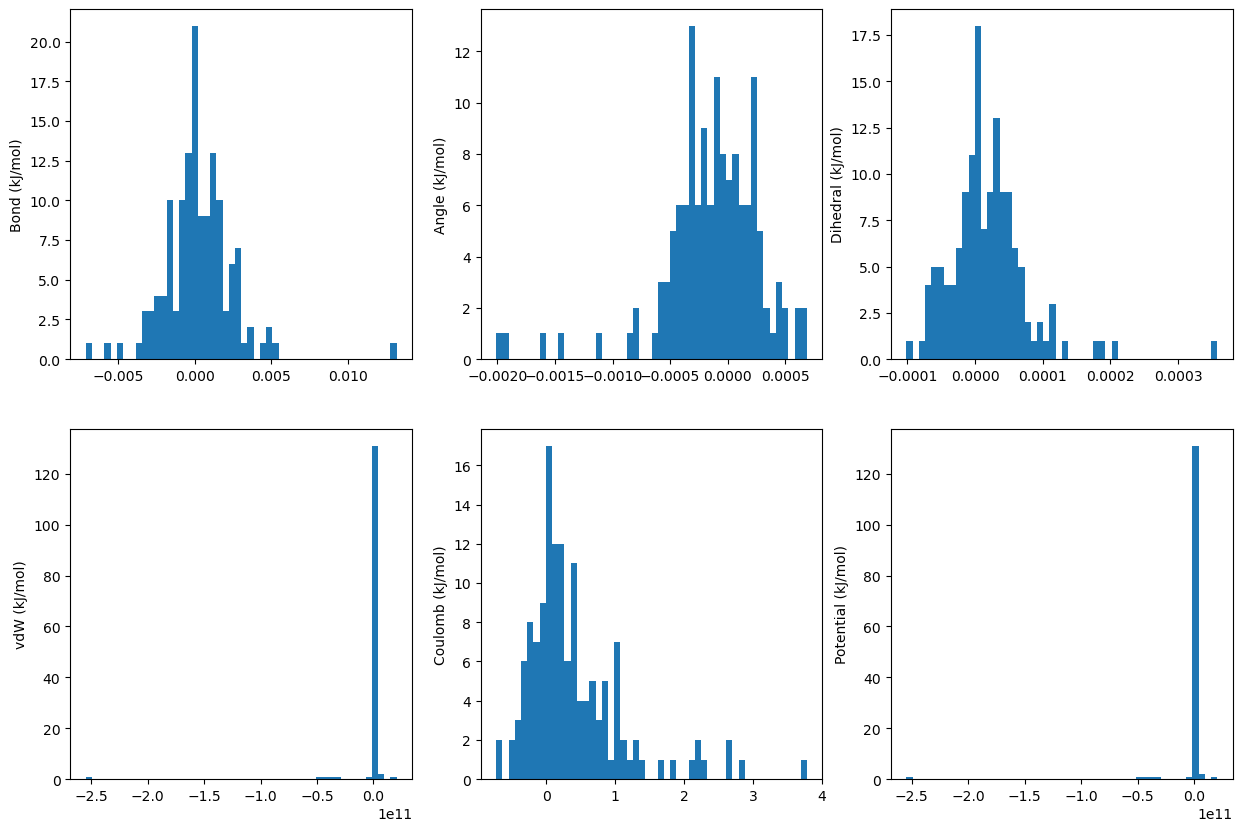

In [75]:
import matplotlib.pyplot as plt
from polymerist.graphics.plotutils import presize_subplots

fig, ax = presize_subplots(nrows=2, ncols=3)
for col, axis in zip(col_order, ax.flatten()):
    heights, bins, patches = axis.hist([i._value for i in diff[col]], bins=50)
    axis.set_ylabel(f'{col} (kJ/mol)')

In [76]:
diff['vdW'].sort_values()

polyester                poly(Ethane-1,2-diol-co-hexanedioic acid)                                                                                                                                                                            -254812235120.0 kJ/mol
polyamide                poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluoromethyl)phenoxy]spiro[fluorene-9,9'-xanthene]-3'-yl]oxy-3-(trifluoromethyl)phenyl]aniline-co-naphthalene-2,6-dicarboxylic acid)                                           -48999618100.5 kJ/mol
                         poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluoromethyl)phenoxy]spiro[fluorene-9,9'-xanthene]-3'-yl]oxy-3-(trifluoromethyl)phenyl]aniline-co-4-[2-(4-carboxyphenyl)-1,1,1,3,3,3-hexafluoropropan-2-yl]benzoic acid)     -43422816319.625 kJ/mol
                         poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluoromethyl)phenoxy]spiro[fluorene-9,9'-xanthene]-3'-yl]oxy-3-(trifluoromethyl)phenyl]aniline-co-5-tert-butylbenzene-1,3-dicarboxylic acid)             

## Evaluating energies with drivers

In [ ]:
from openff.interchange.drivers.openmm import get_openmm_energies, _get_openmm_energies
from openff.interchange.drivers.lammps import get_lammps_energies, _get_lammps_energies,  _find_lammps_executable
from openff.units.openmm import to_openmm as openff_units_to_openmm

In [ ]:
{
    contrib : openff_units_to_openmm(value).in_units_of(kilocalorie_per_mole)
        for contrib, value in get_openmm_energies(interchange, detailed=True, combine_nonbonded_forces=False).energies.items()
}

In [ ]:
get_lammps_energies(interchange).energies